In [1]:
from typing import Callable, Tuple
from finite_distributions.FiniteDistribution import FiniteDistribution
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sinkhorn.SinkhornRunner as SinkhornRunner
import sinkhorn.SinkhornKernels as skern
import visualizer.joint_distribution_visualizer as jdv

In [2]:
def gaussian_prob(mu: float, sigma: float, x: float):
    return np.exp(-(x - mu)**2 / (2 * sigma * sigma))

In [3]:
mu_1 = -0.0
sigma_1 = 1.0

mu_2 = 0.0
sigma_2 = 1.0

In [4]:
xs = [round(x, 5) for x in np.linspace(-5, 5, 25)]

In [5]:
s1 = np.sum([gaussian_prob(mu_1, sigma_1, x) for x in xs])
s2 = np.sum([gaussian_prob(mu_2, sigma_2, x) for x in xs])

dist_1 = FiniteDistribution({x: gaussian_prob(mu_1, sigma_1, x) / s1 for x in xs})
dist_2 = FiniteDistribution({x: gaussian_prob(mu_2, sigma_2, x) / s2 for x in xs})

In [6]:
epsilon = 1.0
c = lambda x, y: (x - y)**2

In [7]:
def unregularized_transport_map(x: float) -> float:
    return mu_2 + (x - mu_1) * (sigma_2/sigma_1)

In [8]:
xs2 = np.linspace(-5, 5, 25)
ys2 = [round(unregularized_transport_map(x), 8) for x in xs2]
new_dict = {(x, y): 0 if np.abs(y - unregularized_transport_map(x)) > 1e-8 else gaussian_prob(mu_1, sigma_1, x) / s1 for x in xs2 for y in ys2 if np.abs(x) <= 5 and np.abs(y) <= 5}
new_dict_sum = np.sum(list(new_dict.values()))
new_dict = {tup: new_dict[tup] / new_dict_sum for tup in new_dict}
optimal_transport = FiniteDistribution(new_dict)

In [10]:
# p-norm
ps = [1.01, 1.1, 1.5, 2., 3., 5.]
sinkhorn_runners = {}
for p in ps:
    sinkhorn_runners[p] = skern.get_pnorm_regularized_runner(p, c)
# entropic
sinkhorn_runner_entropic = skern.get_entropically_regularized_runner(c)


epsilon = 1.
delta = 0.01

sinkhorns_ran = {}
for p in ps:
    (pi_p, f_p, g_p) = sinkhorn_runners[p].run_sinkhorn(dist_1, dist_2, epsilon, delta)
    sinkhorns_ran[p] = (pi_p, f_p, g_p)
pi_e, f_e, g_e = sinkhorn_runner_entropic.run_sinkhorn(dist_1, dist_2, epsilon, delta)

In [37]:
# p-norm
p = 2.
sinkhorn_runner_2 = skern.get_pnorm_regularized_runner(p, c)
epsilons = [0.025, 0.1, 0.5, 1., 2., 3.]

delta = 0.01

sinkhorns_ran_eps = {}
for epsilon in epsilons:
    (pi_p, f_p, g_p) = sinkhorn_runner_2.run_sinkhorn(dist_1, dist_2, epsilon, delta)
    sinkhorns_ran_eps[epsilon] = (pi_p, f_p, g_p)

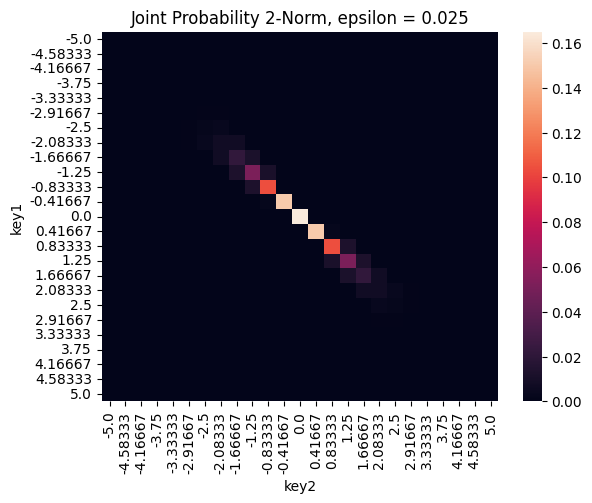

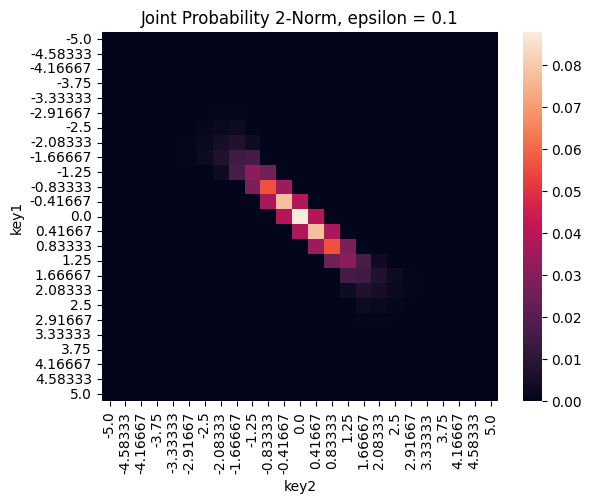

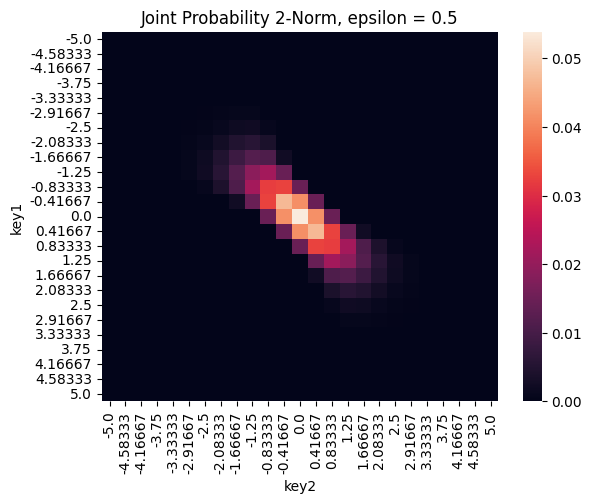

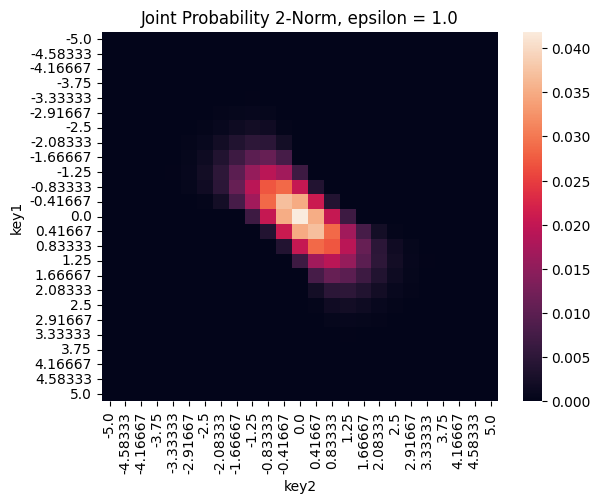

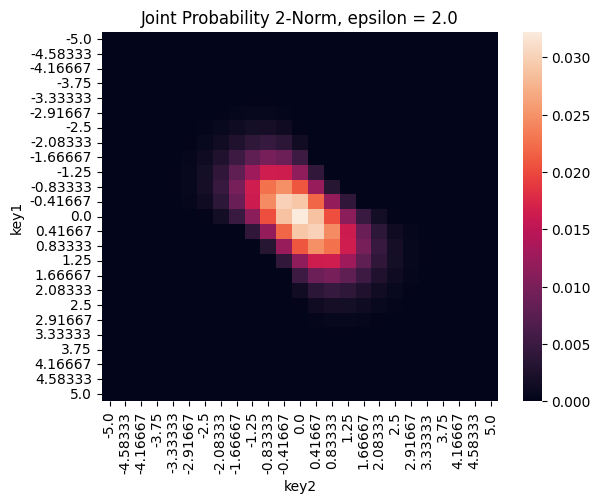

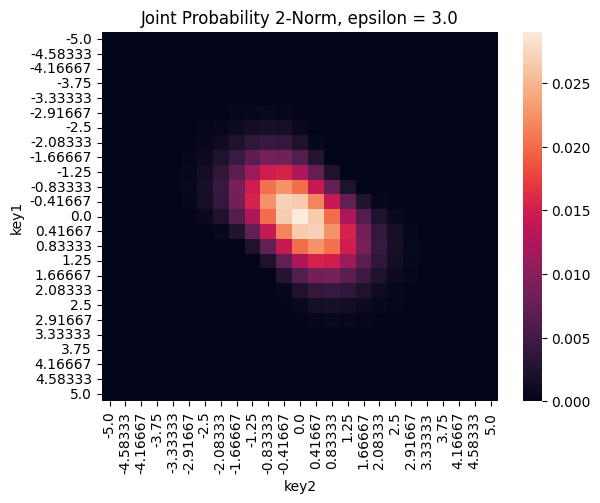

In [39]:
for epsilon in epsilons:
    pi_p = sinkhorns_ran_eps[epsilon][0]
    jdv.visualize_joint_probability(pi_p, title = f"Joint Probability 2-Norm, epsilon = {epsilon}", annot = False)

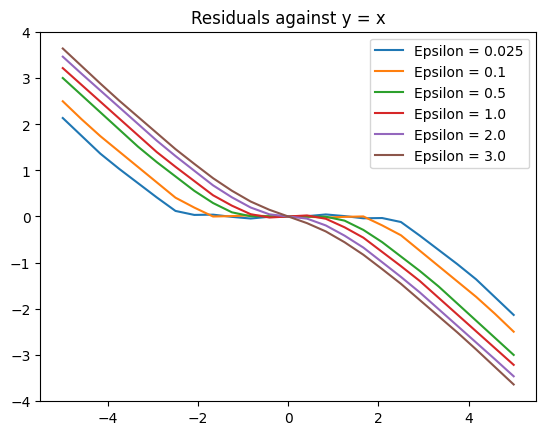

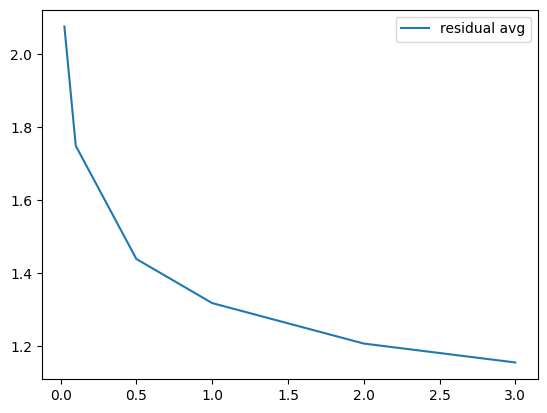

In [38]:
plt.figure()
residAvgs = []
for epsilon in epsilons:
    (pi_p, f_p, g_p) = sinkhorns_ran_eps[epsilon]
    xs = sorted(list(f_p.keys()))
    ys = list(g_p.keys())
    conditionals = []
    for x in xs:
        totSumProb = 0
        totSumWeighted = 0
        for y in ys:
            prob = pi_p.get_probability((x, y))
            totSumProb += prob
            totSumWeighted += prob * y
        conditionals.append(0 if totSumProb == 0 else totSumWeighted/totSumProb)
    plt.plot(xs, [conditionals[i] - xs[i] for i in range(len(xs))], label = f"Epsilon = {epsilon}")
    residAvg = np.mean([np.abs(conditionals[i] - xs[i]) for i in range(len(xs))])
    residAvgs.append(residAvg)
# plt.plot(xs, xs, label = 'true')
plt.title("Residuals against y = x")
plt.legend()
plt.show()

plt.figure()
plt.plot(epsilons, [residAvgs[i] / np.power(epsilons[i], 0.33) for i in range(len(epsilons))], label = "residual avg")
# plt.plot(epsilons, [ for epsilon in epsilons], label = "epsilon ^ 1/3")
plt.legend()
plt.show()
